# Sloan Digital Sky Survey RD14
Classification of Stars, Galaxies and Quasars

https://www.kaggle.com/lucidlenn/sloan-digital-sky-survey/home

## Import libraries

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from xgboost import XGBClassifier
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')

/usr/lib/python3/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load the data
Assumes data is clean.

In [2]:
# set url as the file path if csv is stored locally
url = "sloan-digital-sky.csv"

# column name of the class (y-label)
class_name = 'class'

# adjust header parameter if required
dataset = pandas.read_csv(url, header=0)

## Analyse the data

In [3]:
# check the dimensions (no. of rows and columns)
num_rows = dataset.shape[0]
num_cols = dataset.shape[1]
print(dataset.shape)

(10000, 18)


In [4]:
# check the data types
pandas.set_option('display.max_rows', 500)
print(dataset.dtypes)

objid        float64
ra           float64
dec          float64
u            float64
g            float64
r            float64
i            float64
z            float64
run            int64
rerun          int64
camcol         int64
field          int64
specobjid    float64
class         object
redshift     float64
plate          int64
mjd            int64
fiberid        int64
dtype: object


In [5]:
# peek at the first 10 rows
pandas.set_option('display.width', 100)
print(dataset.head(10))

          objid          ra       dec         u         g         r         i         z  run  \
0  1.237650e+18  183.531326  0.089693  19.47406  17.04240  15.94699  15.50342  15.22531  752   
1  1.237650e+18  183.598371  0.135285  18.66280  17.21449  16.67637  16.48922  16.39150  752   
2  1.237650e+18  183.680207  0.126185  19.38298  18.19169  17.47428  17.08732  16.80125  752   
3  1.237650e+18  183.870529  0.049911  17.76536  16.60272  16.16116  15.98233  15.90438  752   
4  1.237650e+18  183.883288  0.102557  17.55025  16.26342  16.43869  16.55492  16.61326  752   
5  1.237650e+18  183.847174  0.173694  19.43133  18.46779  18.16451  18.01475  18.04155  752   
6  1.237650e+18  183.864379  0.019201  19.38322  17.88995  17.10537  16.66393  16.36955  752   
7  1.237650e+18  183.900081  0.187473  18.97993  17.84496  17.38022  17.20673  17.07071  752   
8  1.237650e+18  183.924588  0.097246  17.90616  16.97172  16.67541  16.53776  16.47596  752   
9  1.237650e+18  183.973498  0.081626  1

In [6]:
# summarise the distribution of each column (to 3 decimal places)
pandas.set_option('precision', 3)
print(dataset.describe())

           objid         ra        dec          u          g          r          i          z  \
count  1.000e+04  10000.000  10000.000  10000.000  10000.000  10000.000  10000.000  10000.000   
mean   1.238e+18    175.530     14.836     18.619     17.372     16.841     16.584     16.423   
std    0.000e+00     47.783     25.212      0.829      0.945      1.068      1.142      1.203   
min    1.238e+18      8.235     -5.383     12.989     12.800     12.432     11.947     11.610   
25%    1.238e+18    157.371     -0.539     18.178     16.815     16.173     15.854     15.618   
50%    1.238e+18    180.395      0.404     18.853     17.495     16.859     16.555     16.390   
75%    1.238e+18    201.547     35.649     19.259     18.010     17.513     17.259     17.141   
max    1.238e+18    260.884     68.542     19.600     19.919     24.802     28.180     22.833   

             run    rerun     camcol      field  specobjid   redshift      plate        mjd  \
count  10000.000  10000.0  1000

In [7]:
# see a breakdown of the class values
print(dataset.groupby(class_name).size())

class
GALAXY    4998
QSO        850
STAR      4152
dtype: int64


In [8]:
# set plotting parameters (adjust based on dataset no. of columns)
figsize = (9,9)
layout = (4,4)
subplots = True
sharex = False
sharey = False
xlabelsize = 10
ylabelsize = 10
fontsize = 10

In [9]:
# names of attributes to plot
plotattrs = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run',  'rerun', 'camcol', 'field', 'redshift', 'plate', 'mjd', 'fiberid']

# dataset of only attributes to plot
plotset = dataset[plotattrs]

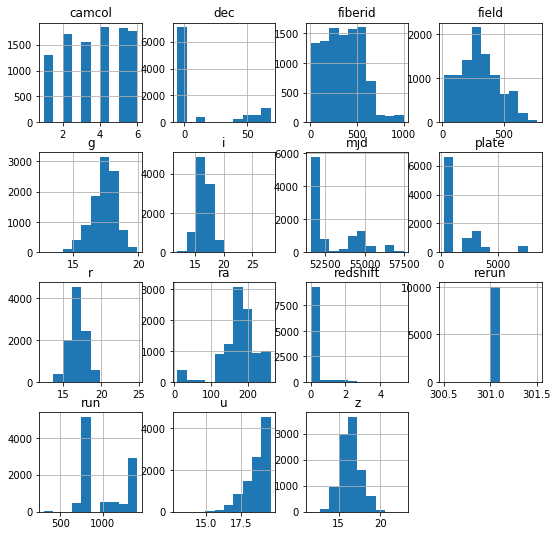

In [10]:
# see the histograms
plotset.hist(sharex=sharex, sharey=sharey, xlabelsize=xlabelsize, ylabelsize=ylabelsize, figsize=figsize)
plt.show()

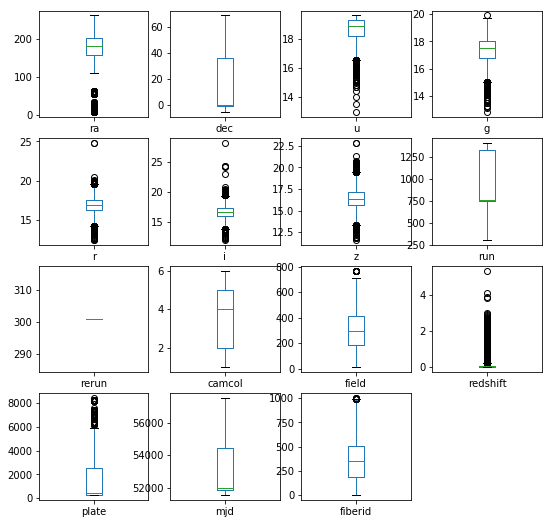

In [11]:
# see the box plots
plotset.plot(kind='box', subplots=subplots, layout=layout, sharex=sharex, sharey=sharey, fontsize=fontsize, figsize=figsize)
plt.show()

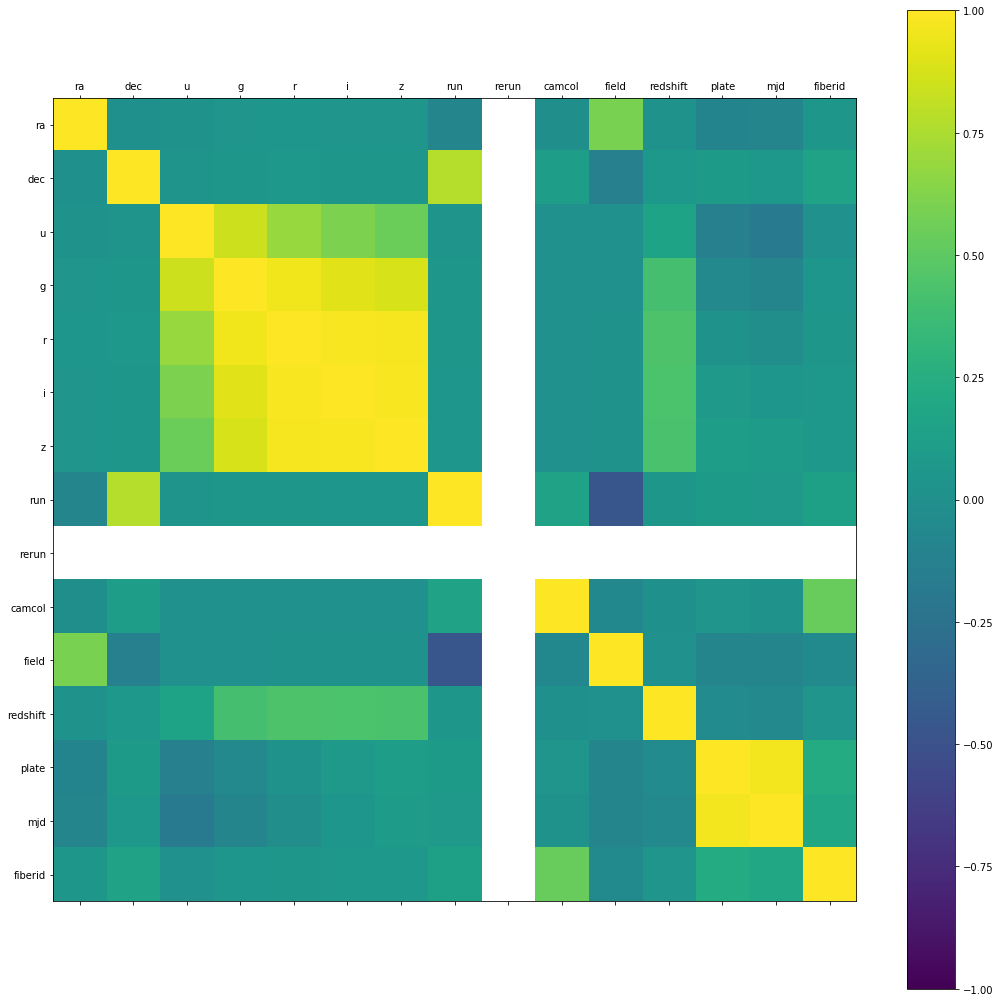

In [12]:
# correlation matrix
correlations = plotset.corr()
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = numpy.arange(0,plotset.shape[1],1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(plotattrs)
ax.set_yticklabels(plotattrs)
plt.show()

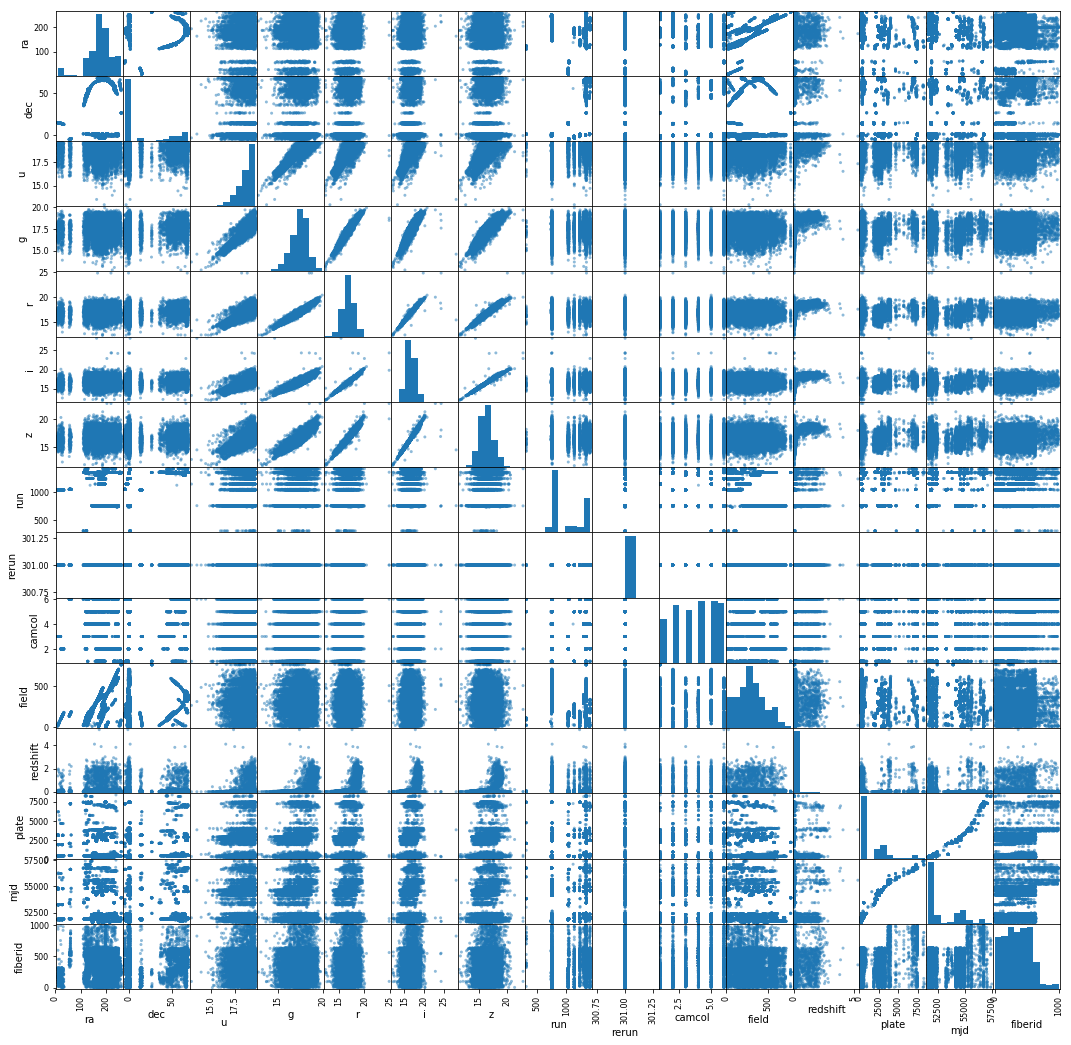

In [13]:
# scatter plot
scatter_matrix(plotset, figsize=(18,18))
plt.show()

## Set up validation hold-out set
To be used at the end of this project to confirm the accuracy of the final model. This template holds back 20% of the dataset from analysis/modeling.

In [14]:
data = dataset.values
class_index = 13

# because the class index is not the right-most column, extracting the features (X) requires additional steps
X1 = data[:,0:class_index]
X2 = data[:,class_index+1:num_cols]
X = numpy.concatenate((X1, X2), axis=1)

# y-labels
y = data[:,class_index]

# encode the string classes as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

In [15]:
validation_size = 0.2     # 20% of the dataset
seed = 8

# not required to use label encoding
#X_train, X_validation, y_train, y_validation = cross_validation.train_test_split(X, label_encoded_y, test_size=validation_size, random_state=seed)
X_train, X_validation, y_train, y_validation = cross_validation.train_test_split(X, y, test_size=validation_size, random_state=seed)

## Evaluate candidate algorithms

In [16]:
# Test options
num_folds = 10
num_instances = len(X_train)

In [17]:
# Evaluation metric
scoring = 'accuracy'

In [18]:
# Spot-check algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [19]:
# Use default tuning parameters for the algorithms
results = []
algorithms = []

for algorithm, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    algorithms.append(algorithm)
    print("%s: %f (%f)" % (algorithm, cv_results.mean(), cv_results.std()))

LR: 0.797750 (0.017355)
LDA: 0.915000 (0.009779)
KNN: 0.787750 (0.015750)
CART: 0.984500 (0.003072)
NB: 0.797375 (0.017252)
SVM: 0.539375 (0.016214)


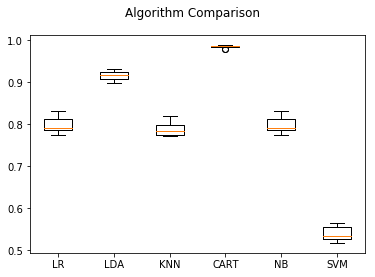

In [20]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(algorithms)
plt.show()

## Re-evaluate with scaled standardised data

In [21]:
# Use pipelines to avoid data leakage
pipelines = []

pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))

results = []
algorithms = []

for algorithm, model in pipelines:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    algorithms.append(algorithm)
    print("%s: %f (%f)" % (algorithm, cv_results.mean(), cv_results.std()))

ScaledLR: 0.952000 (0.005948)
ScaledLDA: 0.906625 (0.009422)
ScaledKNN: 0.903000 (0.008408)
ScaledCART: 0.984000 (0.004395)
ScaledNB: 0.944125 (0.005944)
ScaledSVM: 0.953500 (0.008474)


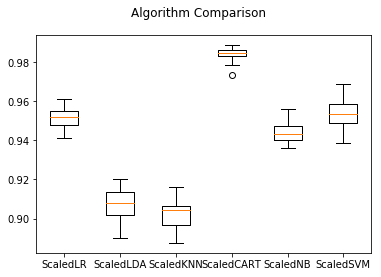

In [22]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(algorithms)
plt.show()

## Evaluate using ensemble methods and stratified k-fold

In [23]:
# Ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
ensembles.append(('XGB', XGBClassifier()))

results = []
algorithms = []

for algorithm, model in ensembles:
    #kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    kfold_stratified = StratifiedKFold(n_splits=num_folds, random_state=seed)
    
    #cv_results = cross_validation.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold_stratified, scoring=scoring)
    
    results.append(cv_results)
    algorithms.append(algorithm)
    print("%s: %f (%f)" % (algorithm, cv_results.mean(), cv_results.std()))

AB: 0.811677 (0.091396)
GBM: 0.989249 (0.003027)
RF: 0.987876 (0.004145)
ET: 0.972628 (0.005777)
XGB: 0.990750 (0.003269)


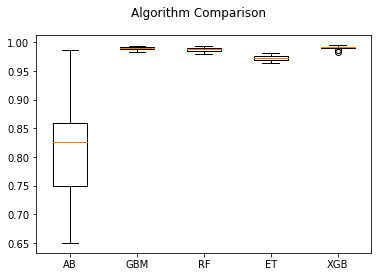

In [24]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(algorithms)
plt.show()

Of all the candidates, XGBoost appears to be the best performing algorithm for this classification problem.

## Parameter tuning
Select the top performing algorithms for parameter tuning

In [25]:
# defaults for xgboost already give promising results

## Finalise the model
Confirm using validation dataset.

In [26]:
# prepare the model
model = XGBClassifier()
model.fit(X_train, y_train)

# estimate accuracy on validation dataset
predictions = model.predict(X_validation)
print(accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))

0.993
[[988   2   0]
 [ 11 163   0]
 [  1   0 835]]
             precision    recall  f1-score   support

     GALAXY       0.99      1.00      0.99       990
        QSO       0.99      0.94      0.96       174
       STAR       1.00      1.00      1.00       836

avg / total       0.99      0.99      0.99      2000



Model predicts with 99.3% accuracy.

Average precision = 99%

Average recall = 99%

Average f1-score = 99%

## Show the feature importance

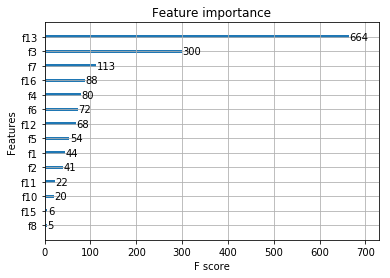

In [27]:
plot_importance(model)
plt.show()

In [28]:
index = 0
features = []

for name in dataset.columns:
    if (name != 'class'):
        features.append(('f'+ str(index), name))
        index = index + 1
    
features

[('f0', 'objid'),
 ('f1', 'ra'),
 ('f2', 'dec'),
 ('f3', 'u'),
 ('f4', 'g'),
 ('f5', 'r'),
 ('f6', 'i'),
 ('f7', 'z'),
 ('f8', 'run'),
 ('f9', 'rerun'),
 ('f10', 'camcol'),
 ('f11', 'field'),
 ('f12', 'specobjid'),
 ('f13', 'redshift'),
 ('f14', 'plate'),
 ('f15', 'mjd'),
 ('f16', 'fiberid')]

Most important feature is redshift.